In [ ]:
%tensorflow_version

Currently selected TF version: 2.x
Available versions:
* 1.x
* 2.x


# **import packages**

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.metrics import r2_score
from sklearn import metrics
import keras
import tensorflow
from tensorflow.keras.layers import LSTM,Bidirectional

# **read data**

In [111]:
input_data=pd.read_csv("Iceland_to_US_16_Frozen_Fish_Fillets_data_50Times.csv",header=0)
data=input_data
input_data.head()

,Time,Fob values,Tonnes
0,1,135.1,129.4
1,2,354.7,308.0
2,3,217.2,192.6
3,4,187.8,166.7
4,5,117.0,97.7


In [112]:
data.shape

(6350, 3)

# **drop unnecessary columns**

In [113]:
data.drop("Time",axis=1,inplace=True)
data.drop("Fob values",axis=1,inplace=True)
data.head()

,Tonnes
0,129.4
1,308.0
2,192.6
3,166.7
4,97.7


# **preprocess data**

In [115]:
data_np=np.array(data)
scaler = MinMaxScaler()
scaler.fit(data_np)
all_data_normalized=scaler.transform(data_np)

#drop label
lbl_normalized=all_data_normalized[:,-1]
data_normalized=all_data_normalized

print("label shape",lbl_normalized.shape)
print("data shape",data_normalized.shape)



label shape (6350,)
data shape (6350, 1)


In [116]:
data_normalized

array([[0.10573446],
       [0.4132943 ],
       [0.21456862],
       ...,
       [0.24005511],
       [0.19304288],
       [0.35388324]])

In [117]:
my_epoch=100
my_batch_size=32

# **create  time series data**

In [118]:
window_size= 4
nfeature=data_normalized.shape[1]

X=[]
y=[]
for i in range(len(data_normalized)-window_size):
    t=[]
    for j in range(0,window_size):
        t.append(data_normalized[[(i+j)], :])
    X.append(t)
    y.append(lbl_normalized[i+ window_size])


data_time_window, lbl_time_window= np.array(X), np.array(y)
data_time_window= data_time_window.reshape(data_time_window.shape[0],window_size, nfeature)
print(data_time_window.shape)
print(lbl_time_window.shape)

(6346, 4, 1)
(6346,)


In [119]:
data_time_window[1:12]

array([[[0.4132943 ],
        [0.21456862],
        [0.16996728],
        [0.05114517]],

       [[0.21456862],
        [0.16996728],
        [0.05114517],
        [0.1994145 ]],

       [[0.16996728],
        [0.05114517],
        [0.1994145 ],
        [0.        ]],

       [[0.05114517],
        [0.1994145 ],
        [0.        ],
        [0.00464956]],

       [[0.1994145 ],
        [0.        ],
        [0.00464956],
        [0.03822972]],

       [[0.        ],
        [0.00464956],
        [0.03822972],
        [0.10194593]],

       [[0.00464956],
        [0.03822972],
        [0.10194593],
        [0.28568968]],

       [[0.03822972],
        [0.10194593],
        [0.28568968],
        [0.45049079]],

       [[0.10194593],
        [0.28568968],
        [0.45049079],
        [0.1994145 ]],

       [[0.28568968],
        [0.45049079],
        [0.1994145 ],
        [0.39176856]],

       [[0.45049079],
        [0.1994145 ],
        [0.39176856],
        [0.56483554]]])

In [120]:
lbl_time_window[1:12]

array([0.1994145 , 0.        , 0.00464956, 0.03822972, 0.10194593,
       0.28568968, 0.45049079, 0.1994145 , 0.39176856, 0.56483554,
       0.60099879])

# **split data into train and test sets**

In [121]:
#split data to train and test sets
train_idx= round(.8 * (data_time_window.shape[0]))
train_data=data_time_window[:train_idx,:]
train_lbl=lbl_time_window[:train_idx]
test_data=data_time_window[train_idx:,:]
test_lbl=lbl_time_window[train_idx:]

# **LSTM Model**

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

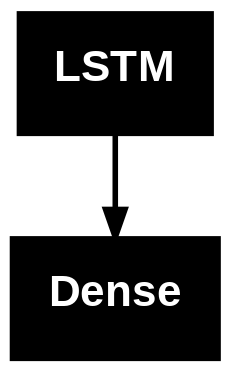

In [122]:
lstm_win_model = keras.models.Sequential()
lstm_win_model.add(keras.layers.LSTM(units=100, input_shape=(data_time_window.shape[1],nfeature)))
lstm_win_model.add(keras.layers.Dense(units=1 ))
lstm_win_model.compile(optimizer="Adam",loss=keras.losses.mean_squared_error,metrics=[tensorflow.metrics.MeanAbsoluteError()])
lstm_win_model.summary()
from tensorflow.keras.utils import plot_model
plot_model(lstm_win_model)

# **Train LSTM model**

In [123]:
lstm_win_model_hist=lstm_win_model.fit(train_data,train_lbl,epochs=my_epoch,batch_size=my_batch_size)

Epoch 1/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0784 - mean_absolute_error: 0.2150
Epoch 2/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0443 - mean_absolute_error: 0.1695
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0458 - mean_absolute_error: 0.1710
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0456 - mean_absolute_error: 0.1725
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0428 - mean_absolute_error: 0.1651
Epoch 6/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0430 - mean_absolute_error: 0.1668
Epoch 7/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0430 - mean_absolute_error: 0.1672
Epoch 8/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0421 - mean_absolute_error: 0.1648
Epoch 9/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0416 - mean_absolute_error: 0.1654
Epoch 10/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0407 - mean_absolute_error: 0.1638
Epoch 11/100
159/15

# **Plot loss and metrics of LSTM during Train**

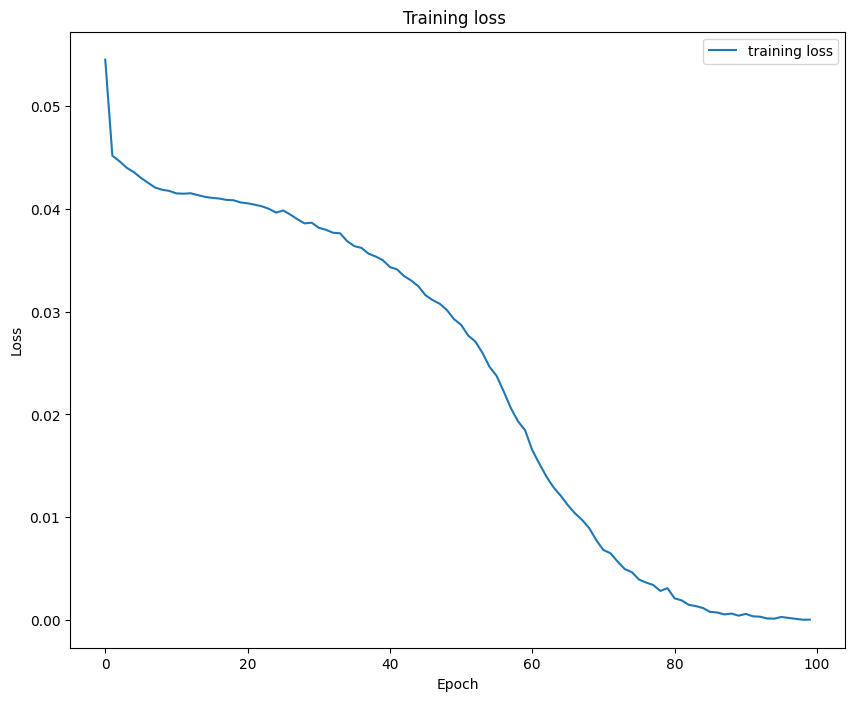

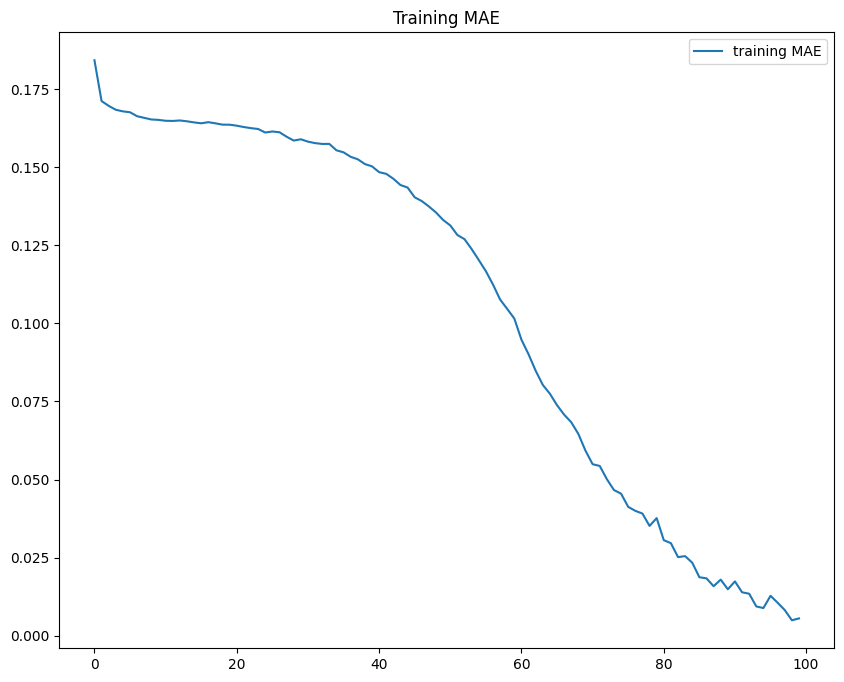

In [124]:
MAE = lstm_win_model_hist.history['mean_absolute_error']
loss = lstm_win_model_hist.history['loss']

plt.figure(figsize=(10,8))
plt.plot(range(my_epoch), loss, label='training loss')
plt.legend(loc='upper right')
plt.title('Training loss ')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.figure(figsize=(10,8))
plt.plot(range(my_epoch), MAE, label='training MAE' )
plt.legend(loc='upper right')
plt.title('Training MAE')
plt.show()


### **test LSTM model**

In [125]:
y_pred_lstm_win=lstm_win_model.predict(test_data,verbose=2)
train_pred_lstm_win=lstm_win_model.predict(train_data,verbose=2)
mse=metrics.mean_squared_error(test_lbl, y_pred_lstm_win)
rmse=metrics.mean_squared_error(test_lbl, y_pred_lstm_win)**0.5
mae= metrics.mean_absolute_error(test_lbl,y_pred_lstm_win)
print('Mean squared error (MSE): %.3f ' % mse)
print('Root mean square error (RMSE) : %.3f '%rmse)
print('Mean Absolute Error (MAE): %.3f'%mae)
print("R2 Score",r2_score(test_lbl,y_pred_lstm_win))
out=np.array([round(mse,3),round(rmse,3),round(mae,3)])

40/40 - 0s - 6ms/step
159/159 - 0s - 1ms/step
Mean squared error (MSE): 0.000 
Root mean square error (RMSE) : 0.007 
Mean Absolute Error (MAE): 0.006
R2 Score 0.9989489795550877


# **plot train and test predictions vs. real values**

In [126]:
def plot_train_test_lstm(train_pred,y_pred):
  plt.figure(figsize=(10,8))
  plt.plot(lbl_normalized)
  plt.plot([None for i in range(0,window_size)] + [x for x in train_pred])
  plt.plot([None for i in train_pred] + [None for i in range(0,window_size)]+ [x for x in y_pred])
  plt.legend(["Real Data","Train prediction","Test prediction"])

  plt.show()

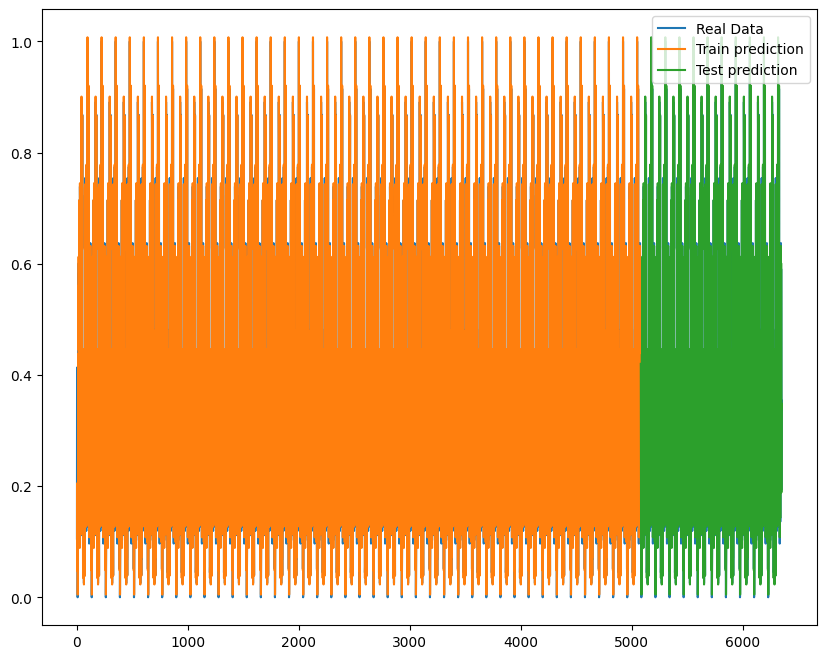

In [127]:
plot_train_test_lstm(train_pred_lstm_win,y_pred_lstm_win)

# **GRU Model**

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 100)            │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,001 (121.10 KB)

 Trainable params: 31,001 (121.10 KB)

 Non-trainable params: 0 (0.00 B)

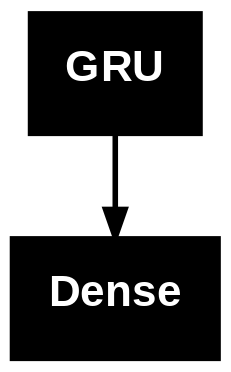

In [131]:
GRU_model = keras.models.Sequential()
GRU_model.add(keras.layers.GRU(units=100,kernel_initializer='glorot_uniform',  input_shape=(data_time_window.shape[1],nfeature)))
GRU_model.add(keras.layers.Dense(units=1 ))
GRU_model.compile(optimizer="Adam",loss=keras.losses.mean_squared_error,metrics=[tensorflow.metrics.MeanAbsoluteError()])
GRU_model.summary()
from tensorflow.keras.utils import plot_model
plot_model(GRU_model)

# **Train GRU Model**

In [132]:
GRU_model_hist=GRU_model.fit(train_data,train_lbl,epochs=my_epoch,batch_size=my_batch_size)


Epoch 1/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0634 - mean_absolute_error: 0.1974
Epoch 2/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0437 - mean_absolute_error: 0.1683
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0426 - mean_absolute_error: 0.1651
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0417 - mean_absolute_error: 0.1639
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0436 - mean_absolute_error: 0.1683
Epoch 6/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0406 - mean_absolute_error: 0.1628
Epoch 7/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0417 - mean_absolute_error: 0.1643
Epoch 8/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0404 - mean_absolute_error: 0.1627
Epoch 9/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0422 - mean_absolute_error: 0.1667
Epoch 10/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0421 - mean_absolute_error: 0.1659
Epoch 11/100
159/15

# **plot loss and mae of GRU during train**

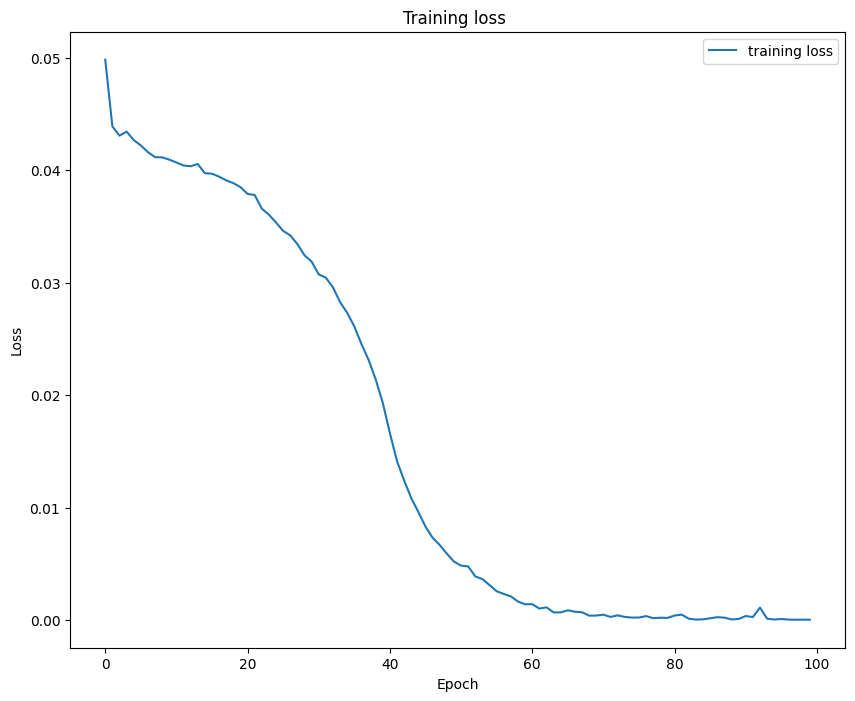

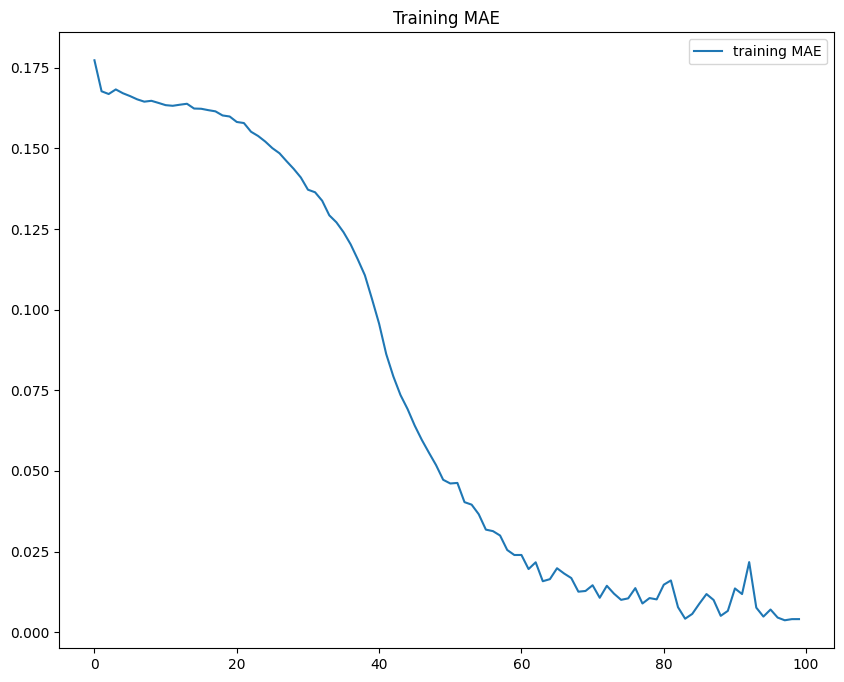

In [133]:

MAE = GRU_model_hist.history['mean_absolute_error']
loss = GRU_model_hist.history['loss']

plt.figure(figsize=(10,8))
plt.plot(range(my_epoch), loss, label='training loss')
plt.legend(loc='upper right')
plt.title('Training loss ')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.figure(figsize=(10,8))
plt.plot(range(my_epoch), MAE, label='training MAE' )
plt.legend(loc='upper right')
plt.title('Training MAE')
plt.show()

# **test GRU model**

In [135]:
y_pred_GRU=GRU_model.predict(test_data,verbose=2)
train_pred_GRU=GRU_model.predict(train_data,verbose=2)
mse=metrics.mean_squared_error(test_lbl, y_pred_GRU)
rmse=metrics.mean_squared_error(test_lbl, y_pred_GRU)**0.5
mae= metrics.mean_absolute_error(test_lbl,y_pred_GRU)
print('Mean squared error (MSE): %.3f ' % mse)
print('Root mean square error (RMSE) : %.3f '%rmse)
print('Mean Absolute Error (MAE): %.3f'%mae)
print("R2 Score",r2_score(test_lbl,y_pred_GRU ))

40/40 - 0s - 6ms/step
159/159 - 1s - 7ms/step
Mean squared error (MSE): 0.000 
Root mean square error (RMSE) : 0.006 
Mean Absolute Error (MAE): 0.005
R2 Score 0.9991737536690171


### **plot train and test predictions vs. real values**

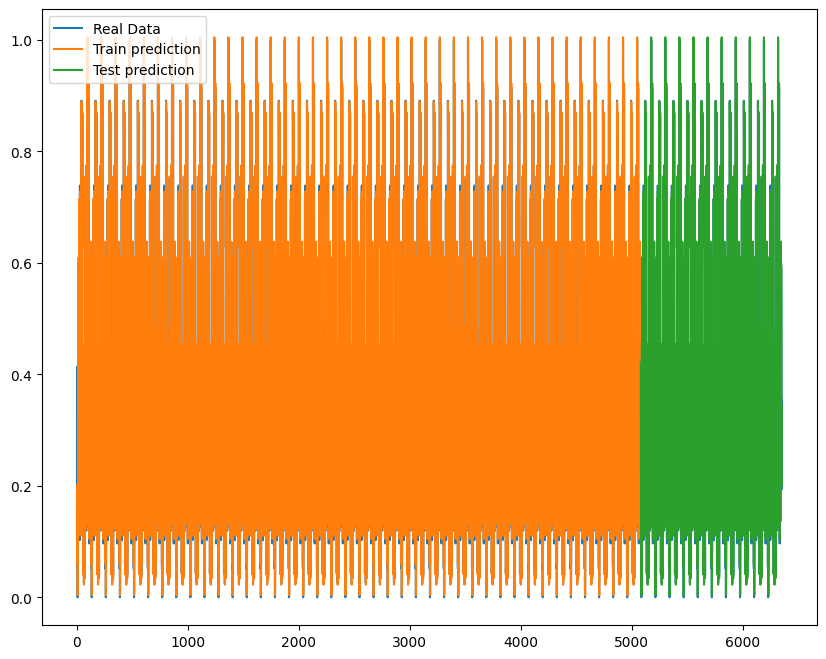

In [136]:
plot_train_test_lstm(train_pred_GRU,y_pred_GRU)

# **Regression models**

# **SVM**

In [140]:
#split data to train and test sets
train_idx= round(.8 * (all_data_normalized.shape[0]))
train_data=all_data_normalized[:train_idx,:]
train_lbl=lbl_normalized[:train_idx]
test_data=all_data_normalized[train_idx:,:]
test_lbl=lbl_normalized[train_idx:]

In [138]:
lbl_normalized=lbl_normalized[:100000]
all_data_normalized=all_data_normalized[:100000,:]
print(lbl_normalized.shape)
print(all_data_normalized.shape)

(6350,)
(6350, 1)


In [144]:
from sklearn.svm import SVR
SVR_regr = SVR()
SVR_regr.fit(train_data, train_lbl)
y_pred_SVR=SVR_regr.predict(test_data)
mse= metrics.mean_squared_error(test_lbl,y_pred_SVR)
mae=metrics.mean_absolute_error(test_lbl,y_pred_SVR)
rmse=metrics.mean_squared_error(test_lbl, y_pred_SVR)**0.5
print('Mean Squared Error: %.2f'% mse)
print('Mean Absolute Error: %.2f'% mae)
print('Root Mean Square Error : %.2f ' %rmse)
print("R2 Score",r2_score(test_lbl,y_pred_SVR ))

Mean Squared Error: 0.01
Mean Absolute Error: 0.07
Root Mean Square Error : 0.08 
R2 Score 0.8863119333165459


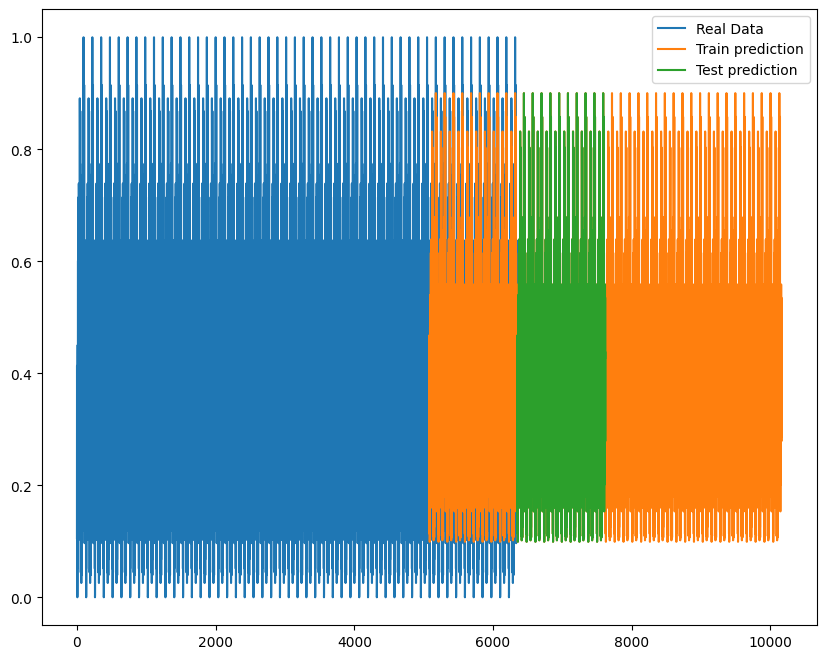

In [145]:
def plot_train_test_regression(train_pred,y_pred):
  plt.figure(figsize=(10,8))
  plt.plot(lbl_normalized)
  plt.plot(np.array([None] * len(train_pred) + [x for x in train_pred]))
  plt.plot(np.array([None] * len(train_pred) + [None] * len(y_pred) + [x for x in y_pred]))
  plt.legend(["Real Data","Train prediction","Test prediction"])

  plt.show()
plot_train_test_regression(SVR_regr.predict(train_data),y_pred_SVR)

# **Decision tree**

In [147]:
from sklearn.tree import  DecisionTreeRegressor
DT_regression=DecisionTreeRegressor(max_depth=5, random_state=0)
DT_regression.fit(train_data, train_lbl)
y_pred_DT=DT_regression.predict(test_data)
mse= metrics.mean_squared_error(test_lbl,y_pred_DT)
mae=metrics.mean_absolute_error(test_lbl,y_pred_DT)
rmse=metrics.mean_squared_error(test_lbl, y_pred_DT)**0.5
print('Mean Squared Error: %.2f'% mse)
print('Mean Absolute Error: %.2f'% mae)
print('Root Mean Square Error : %.2f ' %rmse)
print("R2 Score",r2_score(test_lbl,y_pred_DT ))

Mean Squared Error: 0.00
Mean Absolute Error: 0.01
Root Mean Square Error : 0.01 
R2 Score 0.9989470320925404


# **linear Regression**

In [150]:
from sklearn.linear_model import LinearRegression
lin_regression=LinearRegression()
lin_regression.fit(train_data, train_lbl)
y_pred_lin_reg=lin_regression.predict(test_data)
mse= metrics.mean_squared_error(test_lbl,y_pred_lin_reg)
mae=metrics.mean_absolute_error(test_lbl,y_pred_lin_reg)
rmse=metrics.mean_squared_error(test_lbl, y_pred_lin_reg)**0.5
print('Mean Squared Error: %.2f'% mse)
print('Mean Absolute Error: %.2f'% mae)
print('Root Mean Square Error : %.2f ' %rmse)
print("R2 Score",r2_score(test_lbl,y_pred_lin_reg ))

Mean Squared Error: 0.00
Mean Absolute Error: 0.00
Root Mean Square Error : 0.00 
R2 Score 1.0


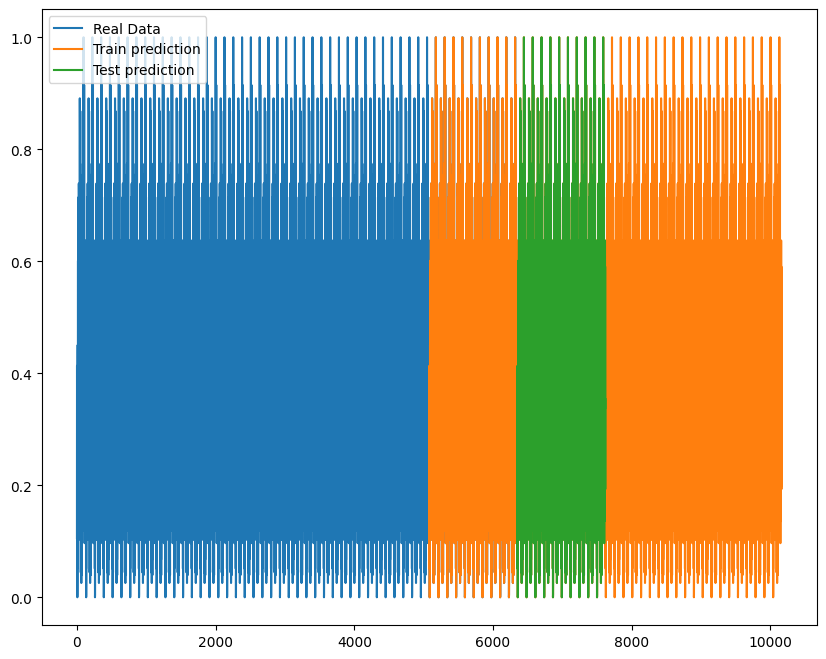

In [151]:
plot_train_test_regression(lin_regression.predict(train_data),y_pred_lin_reg)